In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

df_train = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx")
df_test = pd.read_excel("C:\\Users\\2K\\Desktop\\test.xlsx")

df_train 


,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [13]:
df_train.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


Исходный график

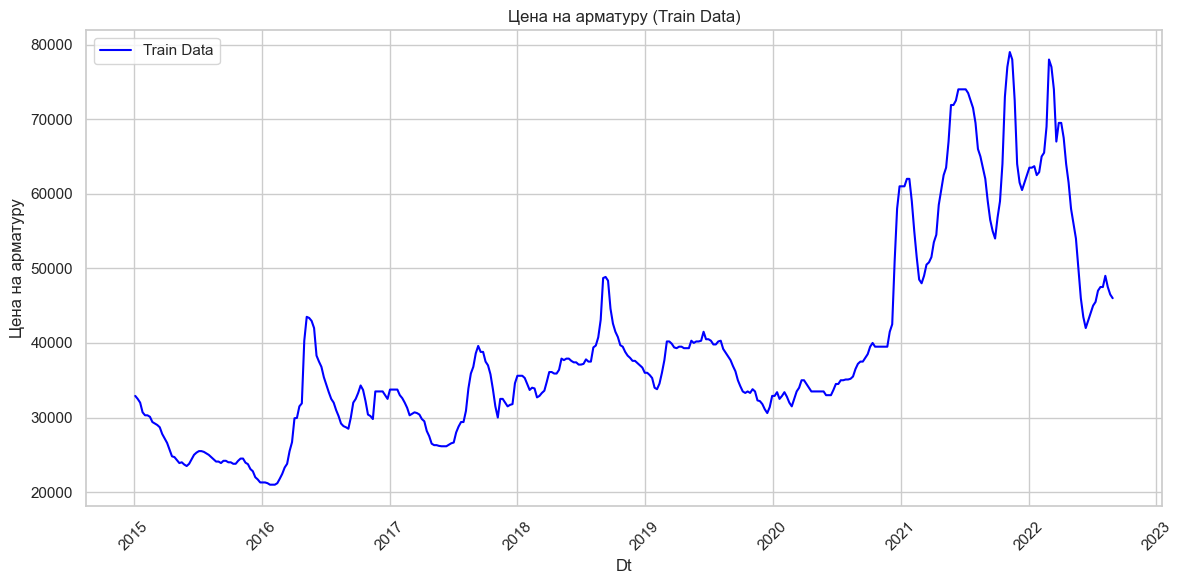

In [3]:
#  Преобразование столбца 'date' в datetime (если он еще не в этом формате)
try:
    df_train['date'] = pd.to_datetime(df_train['dt'])
except KeyError:
    print("Ошибка: Столбец 'dt' не найден. Убедитесь, что столбец с датами называется 'date'.")
    exit()

#  Настройка стиля графиков (необязательно, но улучшает внешний вид)
sns.set(style="whitegrid")

#  Визуализация цен из train.xlsx
plt.figure(figsize=(12, 6))  # Размер графика
plt.plot(df_train['dt'], df_train['Цена на арматуру'], label='Train Data', color='blue')  # Строим график
plt.xlabel('Dt')  # Подпись оси X
plt.ylabel('Цена на арматуру')  # Подпись оси Y
plt.title('Цена на арматуру (Train Data)')  # Заголовок графика
plt.legend()  # Отображение легенды
plt.xticks(rotation=45)  # Поворот подписей на оси X для читаемости
plt.tight_layout()  # Автоматическая корректировка параметров подграфика
plt.show()

Очистка данных


Обработка пропущенных значений...
Пропущенные значения не найдены.

Обработка выбросов...
Выбросы найдены.
            dt  Цена на арматуру
312 2020-12-28             61000
313 2021-01-04             61000
314 2021-01-11             61000
315 2021-01-18             62000
316 2021-01-25             62000
317 2021-02-01             59000
328 2021-04-19             58500
329 2021-04-26             60500
330 2021-05-03             62500
331 2021-05-10             63500
332 2021-05-17             67000
333 2021-05-24             71900
334 2021-05-31             71900
335 2021-06-07             72500
336 2021-06-14             74000
337 2021-06-21             74000
338 2021-06-28             74000
339 2021-07-05             74000
340 2021-07-12             73500
341 2021-07-19             72500
342 2021-07-26             71500
343 2021-08-02             69500
344 2021-08-09             66000
345 2021-08-16             65000
346 2021-08-23             63500
347 2021-08-30             62000
3

C:\Users\2k\AppData\Local\Temp\ipykernel_19440\2282010842.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '58387.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, value_column] = upper_bound # Замена на верхнюю границу


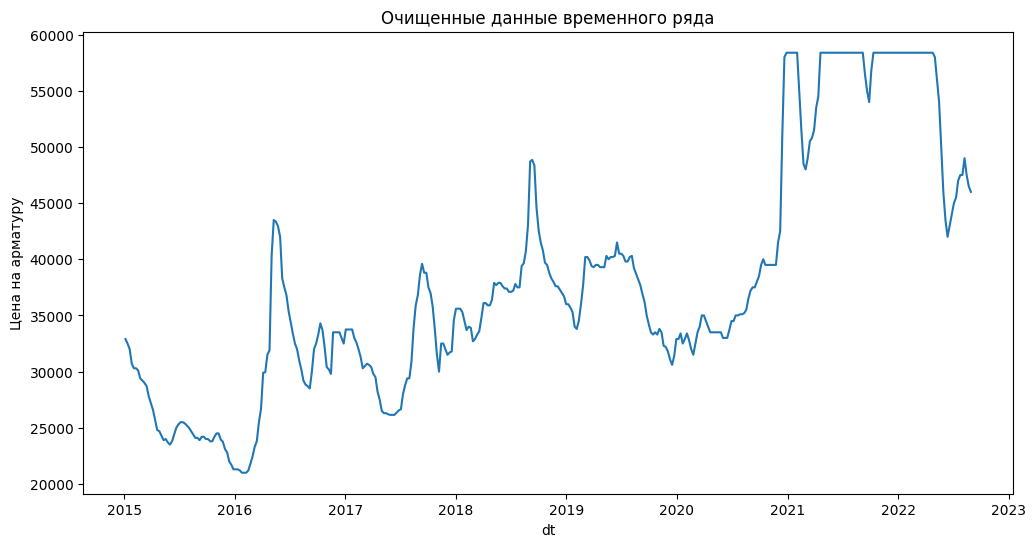


Первые несколько строк очищенных данных:
          dt  Цена на арматуру
0 2015-01-05           32900.0
1 2015-01-12           32500.0
2 2015-01-19           32000.0
3 2015-01-26           30700.0
4 2015-02-02           30300.0


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def clean_data(df, date_column, value_column):
    """
    Очищает данные временного ряда, обрабатывая пропущенные значения и выбросы.

    Аргументы:
        df (pd.DataFrame): DataFrame с временным рядом.
        date_column (str): Имя столбца, содержащего даты.
        value_column (str): Имя столбца, содержащего значения временного ряда.

    Возвращает:
        pd.DataFrame: Очищенный DataFrame.
    """

    # 1. Пропущенные значения
    print("\nОбработка пропущенных значений...")
    if df[value_column].isnull().any():
        print("Пропущенные значения найдены.")
        # a. Заполнение пропущенных значений интерполяцией (линейной)
        df[value_column] = df[value_column].interpolate(method='linear')
        print("Пропущенные значения заполнены линейной интерполяцией.")
    else:
        print("Пропущенные значения не найдены.")

    # 2. Выбросы
    print("\nОбработка выбросов...")
    # a. Определение выбросов с использованием межквартильного размаха (IQR)
    Q1 = df[value_column].quantile(0.25)
    Q3 = df[value_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[value_column] < lower_bound) | (df[value_column] > upper_bound)]

    if not outliers.empty:
        print("Выбросы найдены.")
        print(outliers)

        # b. Замена выбросов на ближайшие не-выбросы (или интерполяция)
        for index, row in outliers.iterrows():
            if row[value_column] < lower_bound:
                df.loc[index, value_column] = lower_bound # Замена на нижнюю границу
            else:
                df.loc[index, value_column] = upper_bound # Замена на верхнюю границу
        print("Выбросы заменены на ближайшие не-выбросы (границы IQR).")


    else:
        print("Выбросы не найдены.")

    # 3. Визуализация (для проверки)
    print("\nВизуализация очищенных данных...")
    plt.figure(figsize=(12, 6))
    plt.plot(df[date_column], df[value_column])
    plt.title("Очищенные данные временного ряда")
    plt.xlabel(date_column)
    plt.ylabel(value_column)
    plt.show()

    return df

# --- Пример использования ---
if __name__ == '__main__':
    # 1. Загрузка данных (замените на свой код загрузки)
    try:
        df = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'])
        date_column = 'dt'
        value_column = 'Цена на арматуру'
    except FileNotFoundError:
        print("Ошибка: Файл 'train.xlsx' не найден. Укажите правильный путь к файлу.")
        exit()
    except KeyError as e:
        print(f"Ошибка: Столбец {e} не найден в файле.")
        exit()

    # 2. Очистка данных
    df_cleaned = clean_data(df.copy(), date_column, value_column)  # Важно: передаем копию DataFrame

    # 3. Вывод первых нескольких строк очищенных данных
    print("\nПервые несколько строк очищенных данных:")
    print(df_cleaned.head())

Разложение времянного ряда

Разложение временного ряда выполнено.


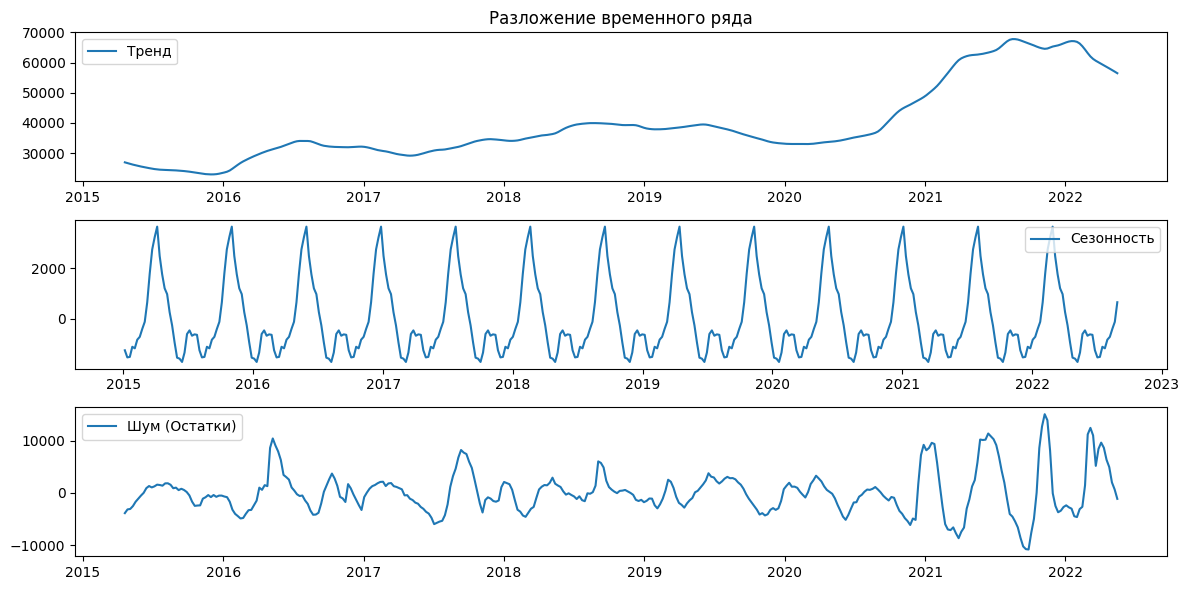

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Загрузка данных
try:
    df_train = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'], index_col='dt')
except FileNotFoundError:
    print("Ошибка: Файл 'train.xlsx' не найден. Укажите правильный путь к файлу.")
    exit()

# 4. Раскладываем временной ряд
try:
    decomposition = seasonal_decompose(df_train['Цена на арматуру'], model='additive', period=30) # period - это длина сезона.  Попробуйте разные значения (например, 7, 30, 365)
    print("Разложение временного ряда выполнено.") # Добавлено для отладки
except ValueError as e:
    print(f"Ошибка при разложении временного ряда: {e}.  Возможно, недостаточно данных для выбранного period.")
    exit()

# Визуализация компонентов (без исходного ряда, с шумом)
plt.figure(figsize=(12, 6))  #Уменьшил высоту графика

plt.subplot(3, 1, 1) #Изменено количество графиков
plt.plot(decomposition.trend, label='Тренд')
plt.legend()
plt.title('Разложение временного ряда')

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Шум (Остатки)') #Изменено название графика
plt.legend()

plt.tight_layout()
plt.show()

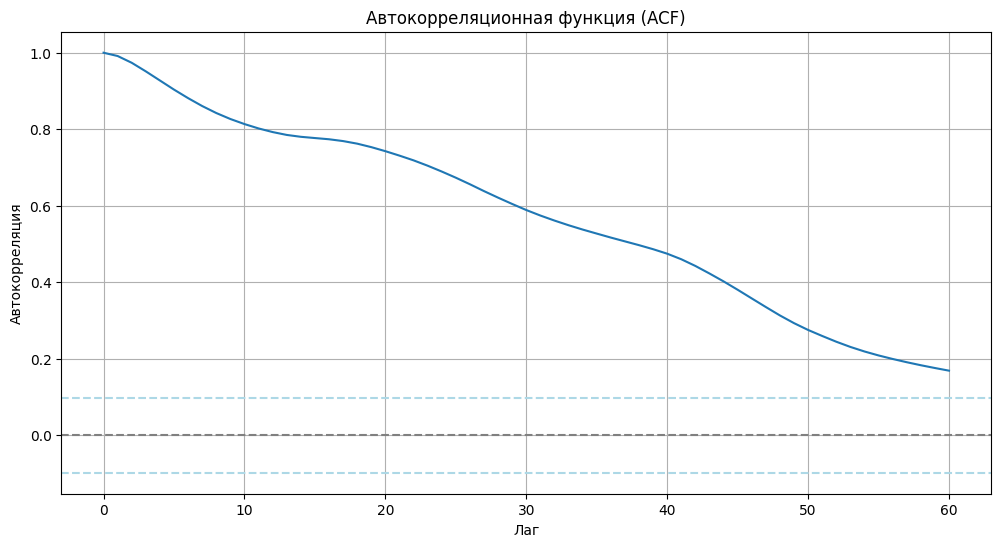

In [4]:
from statsmodels.tsa.stattools import acf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx")

# Вычисление ACF
acf_values = acf(df['Цена на арматуру'], nlags=60)

# Визуализация ACF
plt.figure(figsize=(12, 6))
plt.plot(acf_values)
plt.xlabel("Лаг")
plt.ylabel("Автокорреляция")
plt.title("Автокорреляционная функция (ACF)")
plt.grid(True)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df['Цена на арматуру'])), linestyle='--', color='lightblue')
plt.axhline(y=-1.96/np.sqrt(len(df['Цена на арматуру'])), linestyle='--', color='lightblue')
plt.show()

In [3]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, significance_level=0.05):
    """(Функция как раньше)"""
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1] <= significance_level

# --- Пример использования ---
if __name__ == '__main__':
    # 1. Создание примера временного ряда (замените на свой)
    data = [10, 12, 15, 13, 16, 18, 20, 19, 22, 24]
    series = pd.Series(data) #Можно указать index=pd.date_range() если есть даты

    # 2. Проверка стационарности
    is_stationary = check_stationarity(series)

    if not is_stationary:
        print("Временной ряд нестационарен. Выполняем дифференцирование.")
        series_diff = series.diff().dropna()
        is_stationary_after_diff = check_stationarity(series_diff)

        if is_stationary_after_diff:
            print("Временной ряд стал стационарным после дифференцирования.")
        else:
            print("Временной ряд все еще нестационарен после дифференцирования.  Требуется дальнейшая обработка.")
    else:
        print("Временной ряд стационарен.")

#Теперь нужно проанализировать графики acf/pacf стационарного ряда

ADF Statistic: 1.268928
p-value: 0.996429
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
Временной ряд нестационарен. Выполняем дифференцирование.
ADF Statistic: -36.520143
p-value: 0.000000
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
Временной ряд стал стационарным после дифференцирования.


Графики ACF и PACF

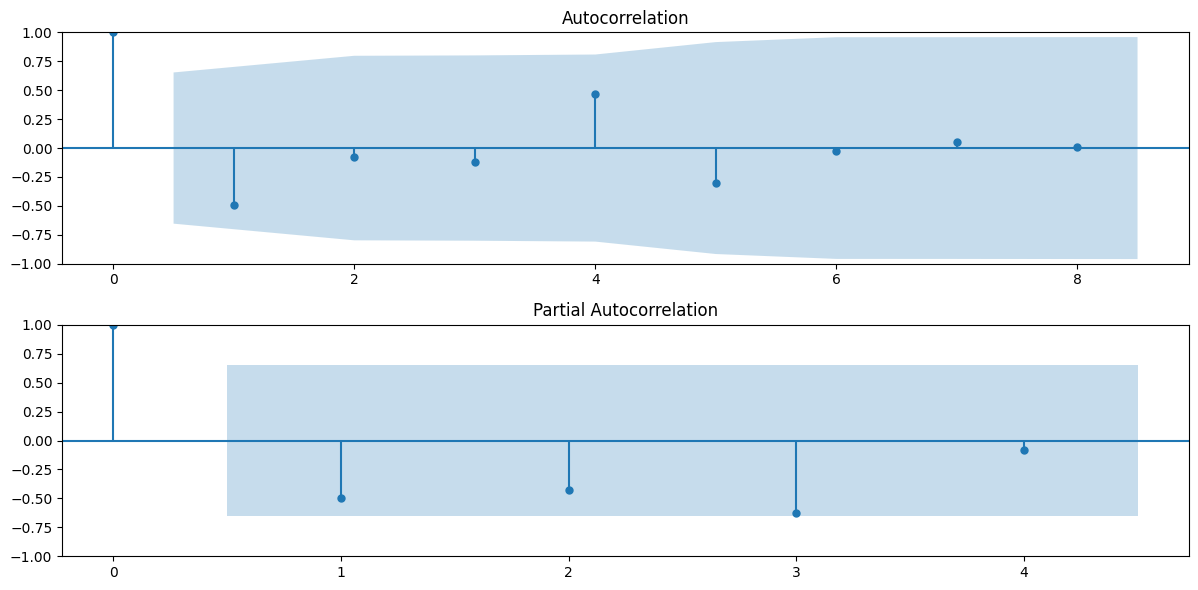

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Предположим, что у вас уже есть загруженные данные и выполненное дифференцирование:
# df = pd.read_excel(...)
# series = df['Цена на арматура']
# series_diff = series.diff().dropna()

# Замените этот блок своими шагами по загрузке и дифференцированию
data = [10, 12, 15, 13, 16, 18, 20, 19, 22, 24] #пример
series = pd.Series(data)
series_diff = series.diff().dropna()

# 2. Построение графиков ACF и PACF ДЛЯ ДИФФЕРЕНЦИРОВАННОГО РЯДА
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(series_diff, ax=ax1, lags=len(series_diff) - 1)
plot_pacf(series_diff, ax=ax2, lags=min(len(series_diff) // 2, len(series_diff) - 1), method='ywm')
plt.tight_layout()
plt.show()

Обучение модели Prophet

11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\2k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


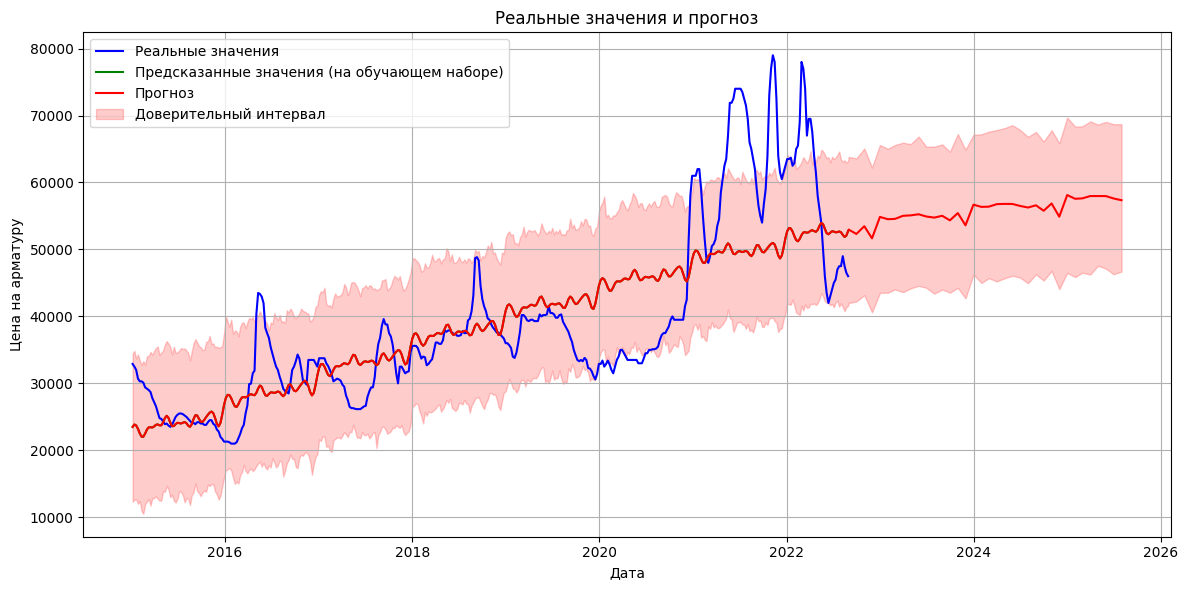

In [30]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. Загрузка данных
df = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'])


# Переименование столбцов для Prophet
df = df.rename(columns={'dt': 'ds', 'Цена на арматуру': 'y'})

# 2. Инициализация и обучение модели Prophet
# Предполагаем, что есть предел роста (cap), который нужно оценить
cap = 60000  # Пример: предел роста равен 60000 (нужно заменить!)
df['cap'] = cap

model = Prophet(
    growth='logistic',  # Используем logistic growth
    yearly_seasonality=True,  # Включаем годовую сезонность
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_prior_scale=0.5  # Установим seasonality_prior_scale в 0.5
)
model.fit(df)

# 3. Создание прогноза
future = model.make_future_dataframe(periods=36, freq='M')
future['cap'] = cap

# Добавляем столбец 'cap' в df для predict
df['cap'] = cap

forecast = model.predict(future)

# 4. Добавляем предсказанные значения к исходному DataFrame для графика
forecast_train = model.predict(df[['ds','cap']]) #Получаем прогноз для тренировочных данных
df['y_predicted'] = forecast_train['yhat']

# 5. Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Реальные значения', color='blue')  # Реальные значения
plt.plot(df['ds'], df['y_predicted'], label='Предсказанные значения (на обучающем наборе)', color='green')  # Предсказанные значения на обучающем наборе
plt.plot(forecast['ds'], forecast['yhat'], label='Прогноз', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2, label='Доверительный интервал')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Реальные значения и прогноз')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\2k\AppData\Local\Temp\ipykernel_19440\765572269.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cap'] = cap
C:\Users\2k\AppData\Local\Temp\ipykernel_19440\765572269.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cap'] = cap
12:49:28 - cmdstanpy - INFO - Chain [1] start processing


Установлен cap: 64226.25


12:49:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\2k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


MAE на тестовой выборке: 8122.37


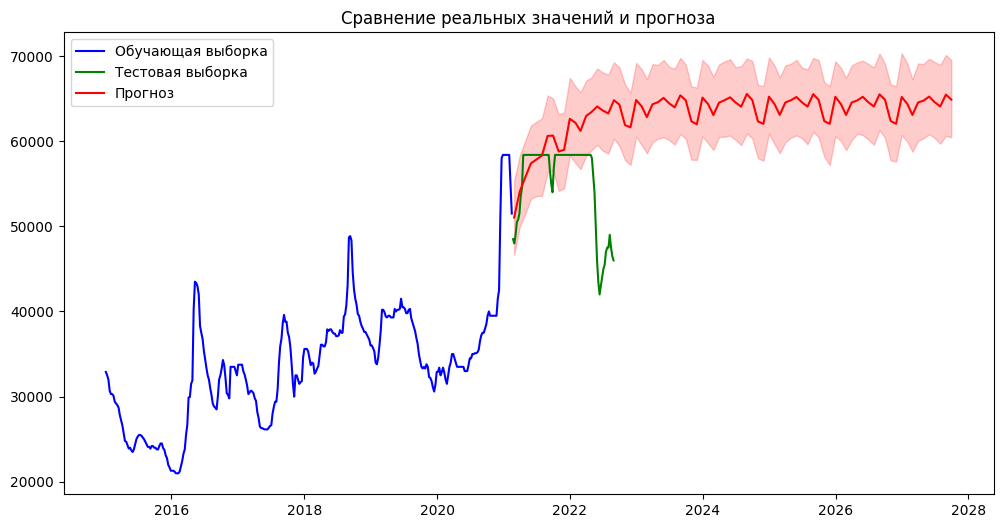

C:\Users\2k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


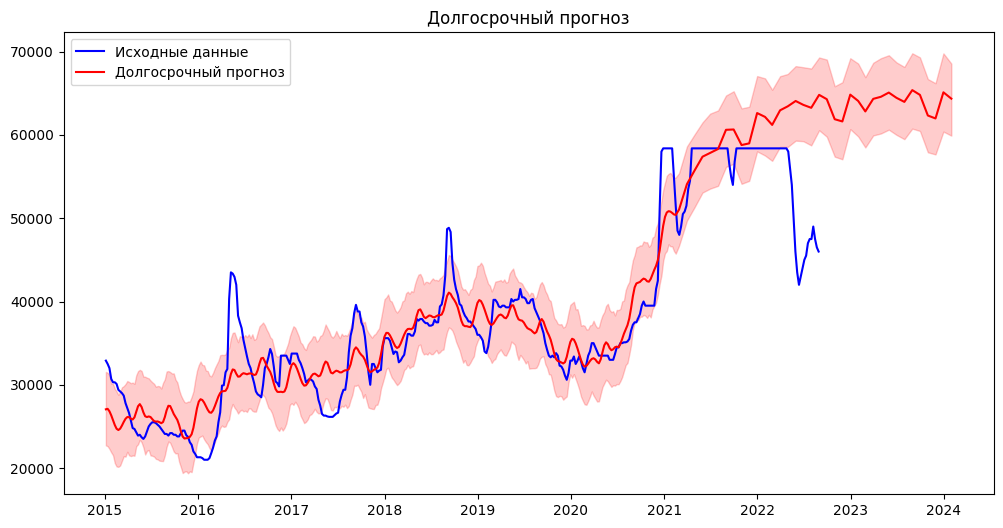

Прогноз сохранен в файл 'forecast.csv'


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# --- 1. Загрузка данных ---
try:
    df_train = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'])
    df_test = pd.read_excel("C:\\Users\\2K\\Desktop\\test.xlsx", parse_dates=['dt'])
    df_train = df_train.rename(columns={'dt': 'ds', 'Цена на арматуру': 'y'})
except FileNotFoundError:
    print("Ошибка: Файл не найден. Убедитесь, что путь к файлу указан правильно.")
    exit()

# --- 2. Обработка пропущенных значений и выбросов ---
def clean_data(df, value_column):
    # Пропущенные значения
    if df[value_column].isnull().any():
        df[value_column] = df[value_column].interpolate(method='linear')
    
    # Выбросы (IQR)
    Q1, Q3 = df[value_column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[value_column] = df[value_column].clip(lower, upper)
    return df

df_train = clean_data(df_train, 'y')

# --- 3. Разделение данных на обучающую и тестовую выборки ---
train_size = int(len(df_train) * 0.8)
train, test = df_train.iloc[:train_size], df_train.iloc[train_size:]

# --- 4. Настройка параметра cap ---
cap = df_train['y'].max() * 1.1  # Максимальное значение + 10% буфера
print(f"Установлен cap: {cap:.2f}")

# Добавляем cap ко всем данным
df_train['cap'] = cap
train['cap'] = cap
test['cap'] = cap

# --- 5. Обучение модели Prophet ---
model = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    seasonality_prior_scale=20,  # Увеличение силы сезонности
    changepoint_prior_scale=0.5,  # Гибкость точек изменения тренда
    changepoint_range=0.9  # Диапазон точек изменения тренда
)

model.fit(train)

# --- 6. Прогнозирование ---
future_test = model.make_future_dataframe(periods=len(test), freq='M')
future_test['cap'] = cap
forecast_test = model.predict(future_test)

# Оценка качества прогноза
mae = mean_absolute_error(test['y'], forecast_test['yhat'][-len(test):])
print(f"MAE на тестовой выборке: {mae:.2f}")

# --- 7. Визуализация результатов ---
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Обучающая выборка', color='blue')
plt.plot(test['ds'], test['y'], label='Тестовая выборка', color='green')
plt.plot(forecast_test['ds'][-len(test):], forecast_test['yhat'][-len(test):], label='Прогноз', color='red')
plt.fill_between(forecast_test['ds'][-len(test):], forecast_test['yhat_lower'][-len(test):], forecast_test['yhat_upper'][-len(test):], color='red', alpha=0.2)
plt.legend()
plt.title("Сравнение реальных значений и прогноза")
plt.show()

# --- 8. Долгосрочный прогноз ---
future_long = model.make_future_dataframe(periods=36, freq='M')
future_long['cap'] = cap
forecast_long = model.predict(future_long)

plt.figure(figsize=(12, 6))
plt.plot(df_train['ds'], df_train['y'], label='Исходные данные', color='blue')
plt.plot(forecast_long['ds'], forecast_long['yhat'], label='Долгосрочный прогноз', color='red')
plt.fill_between(forecast_long['ds'], forecast_long['yhat_lower'], forecast_long['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Долгосрочный прогноз")
plt.show()

# --- 9. Сохранение прогноза ---
forecast_long.to_csv('forecast.csv', index=False)
print("Прогноз сохранен в файл 'forecast.csv'")